Simulation goals

* Categorical response variable

* Different feature distribution for different domains

Simulation

* $D$: total number of features

* $d_{1}$: number of features with higher frequency in a domain 1

* $d_{2}$: number of features with higher frequency in a domain 2


* $d_{1} \sim \operatorname{Unif}(0, \lfloor D/4 \rfloor)$

* $d_{2} \sim \operatorname{Unif}(0, \lfloor D/4 \rfloor)$ ($d_{1} + d_{2} \le D$)

* $k \in [D]$ for indexing feature

* Let $\Delta_{r} = \{j \in [D]: \textrm{feature } j \textrm{ is more frequent in a domain } r \}$

* Sample $\Delta_{1} \subseteq [D]$ such that $|\Delta_{1}| = d_{1}$ 

* Sample $\Delta_{2} \subseteq [D]\backslash \Delta_{1}$ such that $|\Delta_{2}| = d_{2}$

* Let $\alpha_{1} \overset{\Delta}{=} \left( \alpha_{11}, \ldots, \alpha_{1D} \right)$ be a feature frequency vector for a domain 1

* Let $\alpha_{2} \overset{\Delta}{=} \left( \alpha_{21}, \ldots, \alpha_{2D} \right)$ be a feature frequency vector for a domain 2


* For each $k \in [D]$: 

    * If $k \in \Delta_{1}$, $\alpha_{1k} > \alpha_{2k}$

    * If $k \in \Delta_{2}$, $\alpha_{2k} > \alpha_{1k}$

    * Otherwise $\alpha_{1k} = \alpha_{2k}$


* Sample $\rho_{1} \sim \operatorname{Dir}(\alpha_{1})$

* Sample $\rho_{2} \sim \operatorname{Dir}(\alpha_{2})$

* Sample a code-specific contribution to mortality: $W_{i} \sim   \mathcal{N}\!\left(0,1\right)$

* For each patient $i$ in a domain $r$

    * $\tilde{X}_{i} \sim \operatorname{Multi}(n_{i}; \rho_{r})$ where $\tilde{X}_{i}$ is a vector of counts for each diagnosis code/feature, $n_i = 3k$.

	* We set $X_{ik} = \min \left\{ \tilde{X}_{ik}, 1 \right\}$ where $\tilde{X}_{ik}$ is a count for a diagnosis code/feature $k$, $k \in [D]$

* For all patient $i$ in a domain $r$

    * $b = -\operatorname{Mean}(\sum_{k} W_{k} X_{ik})$

* For each patient $i$ in a domain $r$

	* pathogenic score $\bar{p}_{i} = \operatorname{sigmoid}(\sum_{k} W_{k} X_{ik} + b)$ (aka a liability model)

    <!-- * If $\bar{p}_{i} \ge 0.5, Y_{i} = 1$; else $Y_{i} = 0$. -->

	* Sample $Y_{i} \sim \operatorname{Bern}(\bar{p}_{i})$

    * Alternatively, if $\bar{p}_{i} \ge 0.5, Y_{i} = 1$; otherwise, $Y_{i} = 0$

In [1]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")

from common import *
from deep_patient.sda import SDA
from math import floor, exp, ceil
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import dirichlet
import ot
import pandas as pd
from random import randint
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm

base_dir = "/home/wanxinli/deep_patient"

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
""" 
Simulation scheme
"""

def simulate(D, d_1, d_2, num_patient):
    """ 
    Simulate features and labels for domain 1 and domain 2
    :param int D:  total number of features
    :param int d_1: number of features with higher frequency in domain 1
    :param int d_2: number of features with higher frequency in domain 2
    :param int num_patient: number of patients in each domain

    Variables in the implementation are consistent with the variables in the scheme

    TODO: reconsider the choice of alpha_1 and alpha_2

    :return
        list[list[int]] domain 1 features
        list[int] domain 1 labels
        list[list[int]] domain 2 features
        list[int] domain 2 labels
    """

    d_1 = randint(0, floor(0.25*D))
    d_2 = randint(0, floor(0.25*D))
    delta_1 = np.random.choice(size = d_1, a = range(1, D+1), replace=False)
    remaining_set = list(set(list(range(1, D+1)))-set(delta_1))
    delta_2 = np.random.choice(size = d_1, a = remaining_set, replace=False)
    
    unit_1 = 1/(2*d_1-2*d_2+3*D)
    alpha_1 = [5*unit_1]*d_1
    alpha_1.extend([unit_1]*d_2)
    alpha_1.extend([3*unit_1]*(D-d_1-d_2))
  
    unit_2 = 1/(-2*d_1+2*d_2+3*D)
    alpha_2 = [unit_2]*d_1
    alpha_2.extend([5*unit_2]*d_2)
    alpha_2.extend([3*unit_2]*(D-d_1-d_2))  
    W = np.random.normal(size=D)
    W = [abs(W_k) for W_k in W] # only sample positive weights

    def gen_feature_vector_label(alpha):
        """ 
        Generate feature vectors and labels
        :param list[float] alpha: concentration parameteres for the dirichlet distribution
        """

        def sigmoid(x):
            return 1 / (1 + exp(-x))

        rho = dirichlet(alpha=alpha, size=1)[0]
        
        X = []
        Y = []
        b = 0
        all_sum = []

        for _ in range(num_patient):
            X_i = np.random.multinomial(len(rho), rho)
            for k in range(len(X_i)):
                if X_i[k] > 0:
                    X_i[k] = 1 # dominant effect
            X.append(X_i)
            cur_sum = np.sum(np.multiply(W, X_i))
            all_sum.append(cur_sum)
        
        # standardize
        all_sum = preprocessing.scale(all_sum)

        all_sum = np.array(all_sum)
        
        P = []
        for cur_sum in all_sum:
            p_i = sigmoid(cur_sum)
            P.append(p_i)
            Y_i = 0
            if p_i >= 0.5: # TODO: mimic exact logistic regression, change to np.random.binomial later
                Y_i = 1
            # Y_i = np.random.binomial(1, p_i) # too much noise, domain 1 data cannot learn well
            Y.append(int(Y_i))

            
        return X, Y, W, b
    
    def feature_vector_to_feature(feature_vectors):
        """ 
        Convert feature vectors to features
        :param list[list[int]]: feature vectors consisting of indicators

        Returns
            - features consisting of actual codes
        """
        features = []
        for feature_vector in feature_vectors:
            features.append([i for i, e in enumerate(feature_vector) if e != 0])
        return features
    
    def pad_features(features_list):
        """ 
        Pad features to the same length (maximum length of the original features)\
            in each domain by -1
        """
        max_len = 0
        for features in features_list:
            max_len = max(max_len, len(features))

        for i in range(len(features_list)):
            features_list[i] += [-1] * (max_len - len(features_list[i]))
        return features_list



    feature_vector_1, label_1, W_1, b_1 = gen_feature_vector_label(alpha_1)
    feature_1 = pad_features(feature_vector_to_feature(feature_vector_1))
    feature_vector_2, label_2, W_2, b_2 = gen_feature_vector_label(alpha_2)
    feature_2 = pad_features(feature_vector_to_feature(feature_vector_2))
    return np.array(feature_1), label_1, np.array(feature_2), label_2



In [11]:
""" 
Wrapper function with different set ups for simulate()
"""
def simulate_wrapper():
    num_patient = 1000
    D = 20
    d_1 = 8
    d_2 = 8
    return simulate(D, d_1, d_2, num_patient)

In [4]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_seqs, source_seqs):
    """ 
    Customized training algorithm for generating target representations and source representations
    
    :returns: target representations, source representations
    """

    # customized parameters
    nhidden = 3
    nlayer = 1

    # for targets
    # initiate the model
    target_sda = SDA(target_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 100,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    target_sda.train(target_seqs)

    # apply the mode
    target_reps = target_sda.apply(target_seqs)

    # for sources
    # initiate the model
    source_sda = SDA(source_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 100,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    source_sda.train(source_seqs)

    # apply the mode
    source_reps = source_sda.apply(source_seqs)
    return target_reps, source_reps


In [5]:
def plot_scatter(target_reps, target_labels, source_reps, source_labels, trans_source_reps, title):
    target_1 = [i for i, x in enumerate(target_labels) if x == 1]
    target_0 = [i for i, x in enumerate(target_labels) if x == 0]
    source_1 = [i for i, x in enumerate(source_labels) if x == 1]
    source_0 = [i for i, x in enumerate(source_labels) if x == 0]

    fig = plt.figure(figsize=(12, 12))

    ax = fig.add_subplot(projection='3d')
    ax.scatter(target_reps[target_0,0], target_reps[target_0,1], target_reps[target_0,2], color='red', label="target 0", alpha=0.5, facecolors='none', s=130)
    ax.scatter(target_reps[target_1,0], target_reps[target_1,1], target_reps[target_1,2], color='red', label="target 1", alpha=0.5, marker="x", s=130)

    ax.scatter(source_reps[source_0,0], source_reps[source_0,1], source_reps[source_0,2], color='blue', label="source 0", alpha=0.5, facecolors='none', s=100)
    ax.scatter(source_reps[source_1,0], source_reps[source_1,1], source_reps[source_1,2], color='blue', label="source 1", alpha=0.5, marker="x", s=100)

    ax.scatter(trans_source_reps[source_0,0], trans_source_reps[source_0,1], trans_source_reps[source_0,2], color='green', label="trans source 0",  alpha=0.5, facecolors='none', s=70)
    ax.scatter(trans_source_reps[source_1,0], trans_source_reps[source_1,1], trans_source_reps[source_1,2], color='green', label="trans source 1",  alpha=0.5, marker="x", s=70)

    plt.title(title)
    plt.legend()
    plt.show()


In [6]:
def plot_scatter_opp(target_reps, target_labels, source_reps, source_labels, trans_target_reps, title):
    target_1 = [i for i, x in enumerate(target_labels) if x == 1]
    target_0 = [i for i, x in enumerate(target_labels) if x == 0]
    source_1 = [i for i, x in enumerate(source_labels) if x == 1]
    source_0 = [i for i, x in enumerate(source_labels) if x == 0]

    fig = plt.figure(figsize=(12, 12))

    ax = fig.add_subplot(projection='3d')
    ax.scatter(target_reps[target_0,0], target_reps[target_0,1], target_reps[target_0,2], color='red', label="target 0", alpha=0.5, facecolors='none', s=70)
    ax.scatter(target_reps[target_1,0], target_reps[target_1,1], target_reps[target_1,2], color='red', label="target 1", alpha=0.5, marker="x")

    ax.scatter(source_reps[source_0,0], source_reps[source_0,1], source_reps[source_0,2], color='blue', label="source 0", alpha=0.5, facecolors='none', s=70)
    ax.scatter(source_reps[source_1,0], source_reps[source_1,1], source_reps[source_1,2], color='blue', label="source 1", alpha=0.5, marker="x")

    ax.scatter(trans_target_reps[target_0,0], trans_target_reps[target_0,1], trans_target_reps[target_0,2], color='green', label="trans target 0",  alpha=0.5, facecolors='none', s=70)
    ax.scatter(trans_target_reps[target_1,0], trans_target_reps[target_1,1], trans_target_reps[target_1,2], color='green', label="trans target 1",  alpha=0.5, marker="x")

    plt.title(title)
    plt.legend()
    plt.show()


In [12]:
target_accuracy, target_precision, target_recall, target_f1, \
            source_accuracy, source_precision, source_recall, source_f1, \
            trans_source_accuracy, trans_source_precision, trans_source_recall, trans_source_f1 = \
                    entire_proc_binary(simulate_wrapper, custom_train_reps, svm.SVC, max_iter=None)

initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.644
(*) epoch 2, cost 2.155
(*) epoch 3, cost 1.963
(*) epoch 4, cost 1.844
(*) epoch 5, cost 1.764
(*) epoch 6, cost 1.755
(*) training time: 0.10 sec.

training time: 2.00 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.804
(*) epoch 2, cost 0.512
(*) epoch 3, cost 0.388
(*) epoch 4, cost 0.340
(*) epoch 5, cost 0.306
(*) epoch 6, cost 0.281
(*) epoch 7, cost 

In [13]:
target_accuracies, target_precisions, target_recalls, target_f1s, \
    source_accuracies, source_precisions, source_recalls, source_f1s, \
    trans_source_accuracies, trans_source_precisions, trans_source_recalls, trans_source_f1s = \
    run_proc_multi(simulate_wrapper, custom_train_reps, svm.SVC , n_times = 100)

initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.983
(*) epoch 2, cost 1.433
(*) epoch 3, cost 1.385
(*) epoch 4, cost 1.345
(*) epoch 5, cost 1.330
(*) epoch 6, cost 1.332
(*) training time: 0.10 sec.

training time: 0.26 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.722
(*) epoch 2, cost 0.597
(*) epoch 3, cost 0.561
(*) epoch 4, cost 0.570
(*) training time: 0.06 sec.

training time: 0.35 sec.

applying: 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 3
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.737
(*) epoch 2, cost 0.668
(*) epoch 3, cost 0.655
(*) epoch 4, cost 0.629
(*) epoch 5, cost 0.621
(*) training time: 0.08 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.347
(*) epoch 2, cost 1.789
(*) epoch 3, cost 1.675
(*) epoch 4, cost 1.634
(*) epoch 5, cost 1.609
(*) epoch 6, cost 1.589
(*) epoch 7, cost 1.590
(*) training time:

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.030
(*) epoch 2, cost 1.680
(*) epoch 3, cost 1.605
(*) epoch 4, cost 1.560
(*) epoch 5, cost 1.542
(*) epoch 6, cost 1.536
(*) training time: 0.10 sec.

training time: 0.25 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 7
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.760
(*) epoch 2, cost 2.300
(*) epoch 3, cost 2.199
(*) epoch 4, cost 2.158
(*) epoch 5, cost 2.140
(*) epoch 6, cost 2.112
(*) epoch 7, cost 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 3
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.229
(*) epoch 2, cost 0.202
(*) epoch 3, cost 0.183
(*) epoch 4, cost 0.179
(*) training time: 0.06 sec.

training time: 0.22 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.548
(*) epoch 2, cost 0.244
(*) epoch 3, cost 0.179
(*) epoch 4, cost 0.159
(*) epoch 5, cost 0.131
(*) epoch 6, cost 0.126
(*) training time: 0.09 sec.

training time: 0.25 sec.

applying: 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.325
(*) epoch 2, cost 1.015
(*) epoch 3, cost 0.968
(*) epoch 4, cost 0.926
(*) epoch 5, cost 0.914
(*) epoch 6, cost 0.881
(*) epoch 7, cost 0.890
(*) training time: 0.11 sec.

training time: 0.40 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.145
(*) epoch 2, cost 1.773
(*) epoch 3, cost 1.708
(*) epoch 4, cost 1.689
(*) epoch 5, cost 1.656
(*) epoch 6, cost 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.410
(*) epoch 2, cost 0.720
(*) epoch 3, cost 0.595
(*) epoch 4, cost 0.530
(*) epoch 5, cost 0.521
(*) training time: 0.08 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.906
(*) epoch 2, cost 1.627
(*) epoch 3, cost 1.537
(*) epoch 4, cost 1.454
(*) epoch 5, cost 1.429
(*) epoch 6, cost 1.388
(*) epoch 7, cost 1.367
(*) epoch 8, cost 1.386
(*) epoch 9, cost 1.33

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.036
(*) epoch 2, cost 0.652
(*) epoch 3, cost 0.427
(*) epoch 4, cost 0.349
(*) epoch 5, cost 0.304
(*) epoch 6, cost 0.283
(*) epoch 7, cost 0.309
(*) epoch 8, cost 0.305
(*) training time: 0.13 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.366
(*) epoch 2, cost 2.107
(*) epoch 3, cost 2.034
(*) epoch 4, cost 2.012
(*) epoch 5, cost 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.341
(*) epoch 2, cost 0.206
(*) epoch 3, cost 0.168
(*) epoch 4, cost 0.121
(*) epoch 5, cost 0.121
(*) training time: 0.08 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.785
(*) epoch 2, cost 0.318
(*) epoch 3, cost 0.246
(*) epoch 4, cost 0.210
(*) epoch 5, cost 0.165
(*) epoch 6, cost 0.163
(*) training time: 0.09 sec.

training tim

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.492
(*) epoch 2, cost 0.604
(*) epoch 3, cost 0.517
(*) epoch 4, cost 0.480
(*) epoch 5, cost 0.477
(*) training time: 0.08 sec.

training time: 0.38 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 3
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 0.310
(*) epoch 2, cost 0.136
(*) epoch 3, cost 0.106
(*) epoch 4, cost 0.127
(*) epoch 5, cost 0.104
(*) epoch 6, cost 0.110
(*) training time: 0.09 sec.

training tim

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.105
(*) epoch 2, cost 0.570
(*) epoch 3, cost 0.505
(*) epoch 4, cost 0.501
(*) training time: 0.06 sec.

training time: 0.22 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.352
(*) epoch 2, cost 1.130
(*) epoch 3, cost 1.011
(*) epoch 4, cost 0.904
(*) epoch 5, cost 0.862
(*) epoch 6, cost 0.825
(*) epoch 7, cost 0.811
(*) epoch 8, cost 0.793
(*) epoch 9, cost 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.740
(*) epoch 2, cost 1.165
(*) epoch 3, cost 1.063
(*) epoch 4, cost 1.015
(*) epoch 5, cost 0.988
(*) epoch 6, cost 0.954
(*) epoch 7, cost 0.949
(*) training time: 0.11 sec.

training time: 0.42 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.942
(*) epoch 2, cost 1.608
(*) epoch 3, cost 1.500
(*) epoch 4, cost 1.456
(*) epoch 5, cost 1.423
(*) epoch 6, cost 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 7
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.565
(*) epoch 2, cost 2.852
(*) epoch 3, cost 2.658
(*) epoch 4, cost 2.542
(*) epoch 5, cost 2.476
(*) epoch 6, cost 2.432
(*) epoch 7, cost 2.402
(*) epoch 8, cost 2.387
(*) epoch 9, cost 2.367
(*) epoch 10, cost 2.358
(*) training time: 0.16 sec.

training time: 0.46 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.944
(*) epoch 2, cost 1.413
(*) epoch 3, cost

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.842
(*) epoch 2, cost 1.458
(*) epoch 3, cost 1.398
(*) epoch 4, cost 1.377
(*) epoch 5, cost 1.368
(*) training time: 0.08 sec.

training time: 0.24 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.705
(*) epoch 2, cost 1.107
(*) epoch 3, cost 0.879
(*) epoch 4, cost 0.796
(*) epoch 5, cost 0.738
(*) epoch 6, cost 0.722
(*) epoch 7, cost 0.681
(*) epoch 8, cost 

In [14]:
score_path = "../outputs/sim1_svm_scores.csv"
save_scores(target_accuracies, target_precisions, target_recalls, target_f1s, \
        source_accuracies, source_precisions, source_recalls, source_f1s, \
        trans_source_accuracies, trans_source_precisions, trans_source_recalls, trans_source_f1s, score_path)

average trans source to source accuracy increment is -3.4%
median trans source to source accuracy increment is 0.0%
average trans source to source accuracy f1 is -1.7%
median trans source to source accuracy f1 is 0.0%


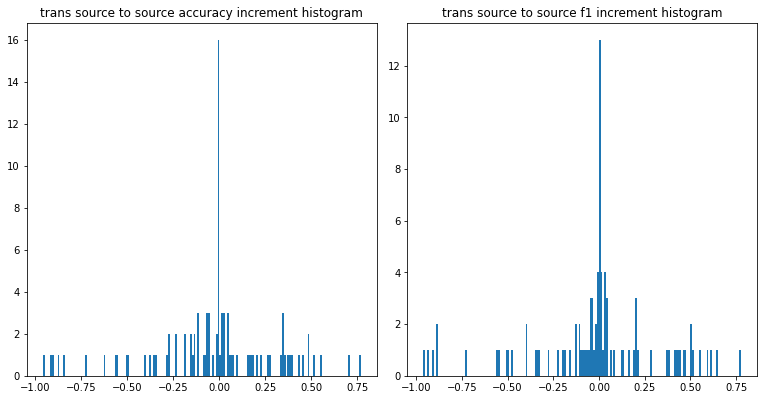

In [15]:
""" 
Larger is better (>0)
"""
hist_plot(score_path, filter=False)

average trans source to source accuracy increment is 6.5%
median trans source to source accuracy increment is 0.8%
average trans source to source accuracy f1 is 9.2%
median trans source to source accuracy f1 is 1.2%


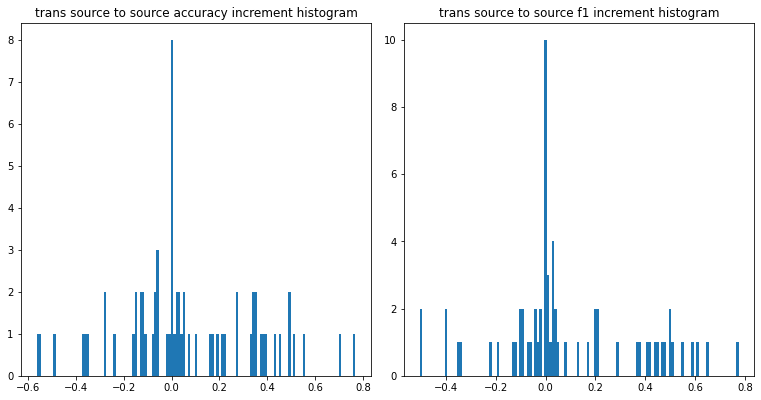

In [16]:
""" 
source accuracy > 0.7 filtered out 
"""

hist_plot(score_path, filter=True)